In [57]:
#############
# SREX masks
#############


import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pylab as plt 
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from six import string_types
from netCDF4 import Dataset


os.chdir('/Users/peterpfleiderer/Documents/Projects/0p5_observed/pdf_processing-srex/')
try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")

# Variable
varin='txx'
read_in_data=da.read_nc('/Users/peterpfleiderer/Documents/Projects/0p5_observed/CCSM4_r1i1p1_txx_hist_rcp85_regrid.nc')['tasmax']

#Set annual time axis for input data 
timeaxis=np.arange(1850,2101)

# Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2010
input_data=da.DimArray(read_in_data[:,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['time', 'lat', 'lon'])

No of non-NAN grid cells in Mask over Ref period:  13824
No of non-NAN grid cells in Mask over Ref period and target period  [1986, 2005]  :  13824
No of non-NAN grid cells in Mask over Ref period and target period  [2011, 2030]  :  13824
No of non-NAN grid cells in Mask over Ref period and target period  [2061, 2080]  :  13824


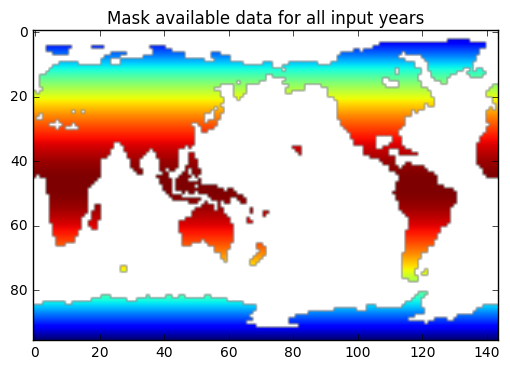

In [58]:
###########
# Settings
###########

# define periods
ref_period=[2005-19,2005]
target_periods=[ref_period,[2030-19,2030],[2080-19,2080]]
period_names=['ref','period1','period2']

# initiate object
varpdf=pdf.PDF_Processing(varin,'/Users/peterpfleiderer/Documents/Projects/0p5_observed/')

# Mask for data availability
# load land-mask if necessary
landmask=da.read_nc('support/144x96_landmask.nc')['landmask']

# get global mask
varpdf.mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods,landmask=landmask)

# Plot global mask
plt.figure()
plt.imshow(varpdf._masks['global'][::-1,:])
plt.title('Mask available data for all input years')

plt.show()

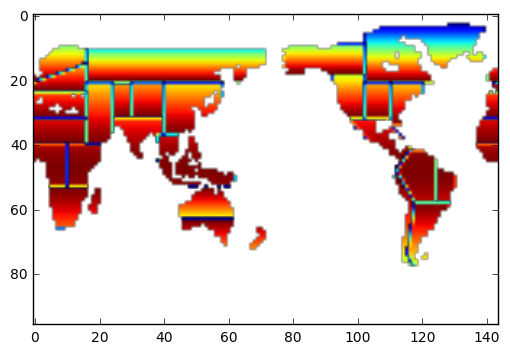

In [59]:
#########
# regional masking
#########

pkl_file = open('support/srex_dict.pkl', 'rb')
srex_polygons = pickle.load(pkl_file)
pkl_file.close()  

varpdf.derive_regional_masking(input_data,shift_lon=-180.0,regions_polygons=srex_polygons)

for region in varpdf._masks.keys():
    if region!='global':
        plt.imshow(varpdf._masks[region][::-1,:])
plt.show()

In [60]:
###########
# Derive time slices and distributions
###########
varpdf.derive_time_slices(input_data,ref_period,target_periods,period_names)
varpdf.derive_distributions()

# compute ks test
varpdf.ks_test('period1','period2')

ref [1986, 2005]
period1 [2011, 2030]
period2 [2061, 2080]


In [61]:
###############
# compare different bandwidth estimation methods
###############

kde_methods_quantiles={}
kde_methods_distributions={}

# R fixed bandwidth
varpdf.derive_distributions()
for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['period1'].min()*0.9,varpdf._distributions[region]['period2'].max()*1.2]
    # Set bandwith for kernel estimate
    bw=(cutinterval[1]-cutinterval[0])/40
    # Derive Kernel estimate
    varpdf.kernel_density_estimation(cutinterval,bw,region=region,method='R')

# get quantiles
varpdf.quantiles_from_cdf() 
kde_methods_quantiles['R_fixed']=varpdf._quantiles
kde_methods_distributions['R_fixed']=varpdf._distributions

# python fixed bandwidth
varpdf.derive_distributions()
for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['period1'].min()*0.9,varpdf._distributions[region]['period2'].max()*1.2]
    # Set bandwith for kernel estimate
    bw=(cutinterval[1]-cutinterval[0])/40
    # Derive Kernel estimate
    varpdf.kernel_density_estimation(cutinterval,bw,region=region,method='python')

# get quantiles
varpdf.quantiles_from_cdf() 
kde_methods_quantiles['python_fixed']=varpdf._quantiles
kde_methods_distributions['python_fixed']=varpdf._distributions

# python silverman
varpdf.derive_distributions()
for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['period1'].min()*0.9,varpdf._distributions[region]['period2'].max()*1.2]
    # Derive Kernel estimate
    varpdf.kernel_density_estimation(cutinterval,bw='silverman',region=region,method='python')

# get quantiles
varpdf.quantiles_from_cdf() 
kde_methods_quantiles['python_silverman']=varpdf._quantiles
kde_methods_distributions['python_silverman']=varpdf._distributions

# python scott
varpdf.derive_distributions()
for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['period1'].min()*0.9,varpdf._distributions[region]['period2'].max()*1.2]
    # Derive Kernel estimate
    varpdf.kernel_density_estimation(cutinterval,bw='scott',region=region,method='python')

# get quantiles
varpdf.quantiles_from_cdf() 
kde_methods_quantiles['python_scott']=varpdf._quantiles
kde_methods_distributions['python_scott']=varpdf._distributions


Error in Kernel Estimation
Error in Kernel Estimation
Error in Kernel Estimation


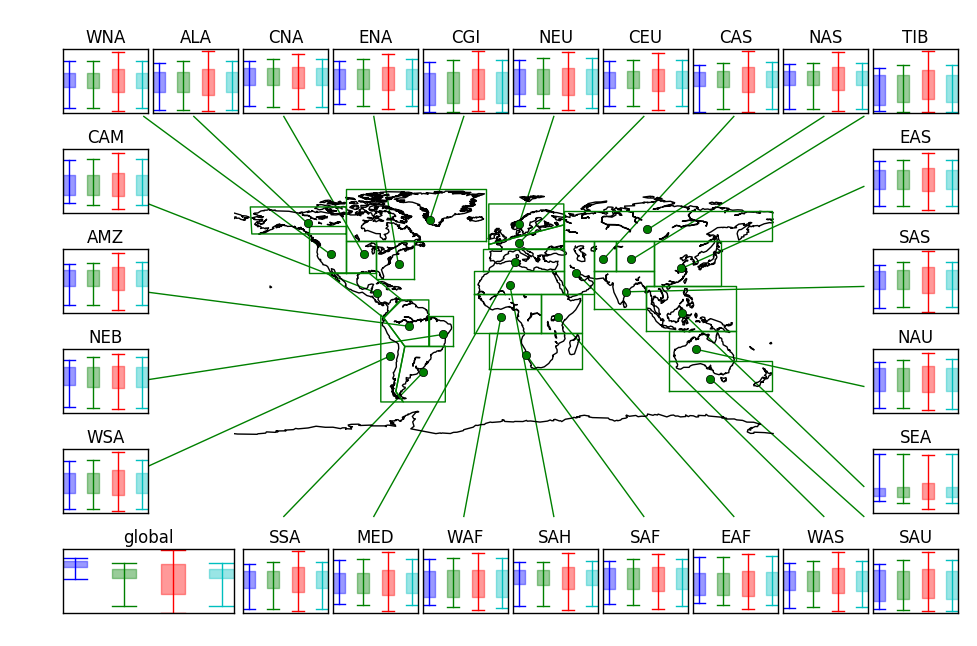

In [62]:
###########
# comparison of estimated quantiles
###########


# plot function applied to all regions
def small_boxplots(subax,region):
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])
    #subax.axis('off')

    colors=['b','g','r','c']
    maxis,minis=[],[]
    for mm in range(4):
        method=kde_methods_quantiles.keys()[mm]
        box=[kde_methods_quantiles[method][region]['period1'][i] for i in [0.25,0.75]]
        subax.add_collection(PatchCollection([patches.Polygon([(mm*2-0.5,box[0]),(mm*2+0.5,box[0]),(mm*2+0.5,box[1]),(mm*2-0.5,box[1])])], alpha=0.4,color=colors[mm]))
        polygon=Polygon([(mm*2-0.5,box[0]),(mm*2+0.5,box[0]),(mm*2+0.5,box[1]),(mm*2-0.5,box[1])]).exterior.xy
        whisker=[kde_methods_quantiles[method][region]['period1'][i] for i in [0.05,0.95]]
        subax.plot([mm*2-0.5,mm*2+0.5],[whisker[0],whisker[0]],color=colors[mm])
        subax.plot([mm*2-0.5,mm*2+0.5],[whisker[1],whisker[1]],color=colors[mm])
        subax.plot([mm*2,mm*2],[whisker[0],whisker[1]],color=colors[mm])
        
        # for axis
        maxis.append(whisker[1])
        minis.append(whisker[0])


    subax.title.set_text(region)
    #subax.set_xlim([3,10])
    subax.set_ylim([min(minis)-1,max(maxis)+1])

# load plot settings
pkl_file = open('support/plot_settings.pkl', 'rb')
plot_settings = pickle.load(pkl_file)
pkl_file.close()  
    
varpdf.show_result(small_boxplots,plot_settings,output_name=None)

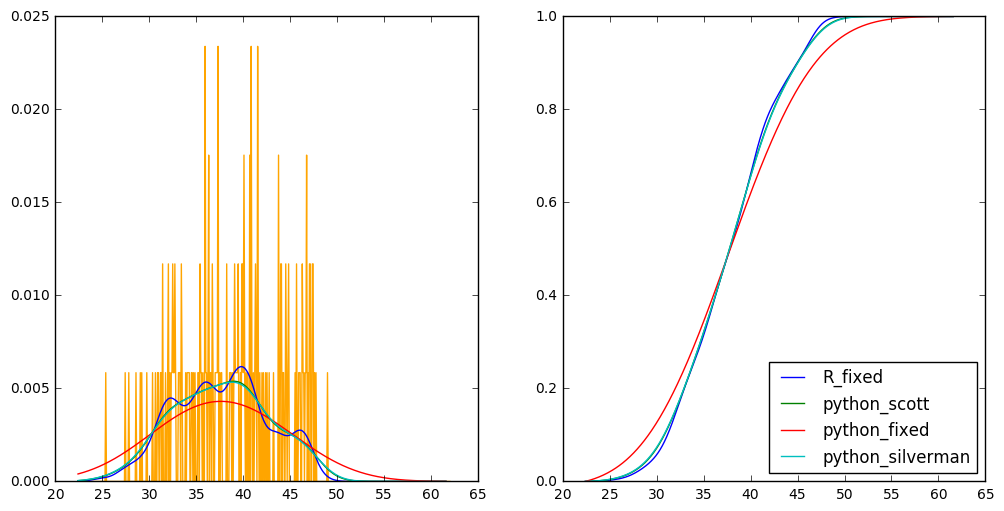

In [66]:
#############
# check KDE performance for individual regions
#############

region='MED'
period='period1'

f,pl=plt.subplots(ncols=2,figsize=(12,6))

distr=np.histogram(varpdf._distributions[region][period], bins=kde_methods_distributions[method][region][period+'_pdf'][:,0], density=True)
pl[0].plot(distr[1][0:-1]+0.5,distr[0]/sum(distr[0]),color='orange')

for method in kde_methods_quantiles.keys():
    pdf_distro=kde_methods_distributions[method][region][period+'_pdf']
    pl[0].plot(pdf_distro[:,0],pdf_distro[:,1],label=method)  
    cdf_distro=kde_methods_distributions[method][region][period+'_cdf']
    pl[1].plot(cdf_distro[:,0],cdf_distro[:,1],label=method)
plt.legend(loc='best')
plt.show()